In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
#import umap
import sklearn.cluster as cluster
import sklearn.manifold as manifold

from cryo_sbi import CryoEmSimulator
from cryo_sbi.inference import priors
import cryo_sbi.utils.estimator_utils as est_utils
import cryo_sbi.utils.image_utils as img_utils
import cryo_sbi.utils.micrograph_utils as mic_utils

from lampe.data import JointLoader, H5Dataset
from cryo_sbi.inference.priors import get_uniform_prior_1d
from itertools import islice

### Setup cell

In [2]:
save_figures = False
test_on_synthetic = True
file_name = "cross_correlation_particles"
path = "../experiments/6wxb/"

estimator_config = "../experiments/6wxb/resnet18_fft_encoder.json"
estimator_weights = "../experiments/6wxb/posterior_6wxb_mixed.estimator"
image_config = "../experiments/6wxb/image_params_mixed_training.json"

In [3]:
assert os.path.isdir(path), f"Path {path} does not exist"
assert path.endswith("/"), f"Path {path} must end with /"
assert os.path.isfile(
    estimator_config
), f"Estimator config {estimator_config} does not exist"
assert os.path.isfile(image_config), f"Image config {image_config} does not exist"

### Load posterior model

In [4]:
estimator = est_utils.load_estimator(
    estimator_config,
    estimator_weights,
    device="cuda",
)

Load experimental data

In [160]:
average_psd = torch.load("../../ceph/cryo_sbi_data/whitening_filter/average_psd_19_micrographs.pt").cuda()

In [184]:
transform = transforms.Compose(
    [
        img_utils.FourierDownSample(256, 128),
        img_utils.WhitenImage(average_psd),
        img_utils.NormalizeIndividual(),
        img_utils.Mask(128, 45),
    ]
)

In [23]:
folder_with_mrc = "/mnt/home/ldingeldein/ceph/cryo_sbi_data/hemagglutinin_all_particles/10532/data/03_Refined_Particles/P30_J363_particles/J342/localmotioncorrected/"

In [24]:
mrc_files = [f"{folder_with_mrc}{mrc_file}" for mrc_file in os.listdir(folder_with_mrc) if mrc_file.endswith(".mrc")]

In [ ]:
all_particles = img_utils.MRCloader(mrc_files, num_workers=32, prefetch_factor=10)

In [ ]:
latent_space = []
means = []
confidence = []


In [ ]:
for idx, particle_batch in all_particles:
    particle_batch = transform(particle_batch.cuda(non_blocking=True))
    latent_batch = est_utils.compute_latent_repr(
        estimator,
        particle_batch,
        batch_size=1000,
        device="cuda"
    )
    samples = est_utils.sample_posterior(
        estimator,
        particle_batch,
        num_samples=10000,
        batch_size=1000,
        device="cuda",
    )
    latent_space.append(latent_batch)
    means_batch = samples.mean(axis=0)
    posterior_quantiles = np.quantile(samples.numpy(), [0.025, 1 - 0.025], axis=0)
    confidence_widths_batch = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()
    means.append(means_batch)
    confidence.append(confidence_widths_batch)
    if idx % 100 == 0:
        print(f"Processed {idx} particles")
    

In [ ]:
latent_space = torch.cat(latent_space, dim=0)
means = torch.cat(means, dim=0)
confidence = np.concatenate(confidence, axis=0)

In [ ]:
np.savez_compressed(
    "all_particles_bfactor_new.npz",
    latent_space=latent_space.cpu().numpy(),
    means=means.cpu().numpy(),
    confidence=confidence,
)

In [5]:
data = np.load("all_particles_bfactor_new.npz")

(array([   70.,   119.,   195.,   241.,   305.,   359.,   418.,   483.,
          560.,   595.,   657.,   758.,   841.,   914.,  1056.,  1143.,
         1314.,  1408.,  1501.,  1737.,  1915.,  2138.,  2363.,  2678.,
         2883.,  3180.,  3442.,  3678.,  4185.,  4433.,  4901.,  5482.,
         5843.,  6252.,  6678.,  7170.,  7773.,  8295.,  8846.,  9264.,
         9826., 10282., 10674., 11071., 11206., 10905., 10467.,  9621.,
         8634.,  7431.,  6766.,  5752.,  4916.,  4007.,  3300.,  2774.,
         2398.,  2152.,  1873.,  1633.,  1401.,  1330.,  1159.,  1085.,
          961.,   844.,   803.,   720.,   663.,   655.,   561.,   537.,
          502.,   475.,   417.,   402.,   404.,   402.,   387.,   372.,
          373.,   337.,   327.,   328.,   326.,   318.,   323.,   310.,
          279.,   299.,   306.,   290.,   303.,   287.,   337.,   306.,
          285.,   230.,   139.,    14.]),
 array([ 0.63966   ,  1.61847019,  2.59728026,  3.57609057,  4.55490065,
         5.53371096, 

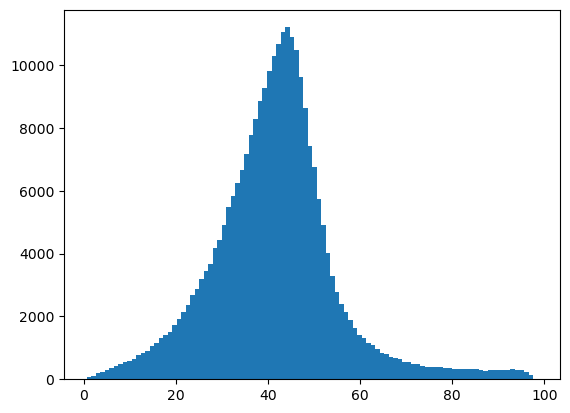

In [6]:
plt.hist(data["means"], bins=100)

(array([  70.,  119.,  195.,  241.,  304.,  343.,  401.,  439.,  475.,
         477.,  456.,  452.,  433.,  416.,  376.,  337.,  338.,  275.,
         302.,  264.,  256.,  246.,  275.,  262.,  290.,  260.,  239.,
         264.,  261.,  291.,  275.,  337.,  316.,  336.,  439.,  471.,
         527.,  629.,  693.,  840.,  868., 1048., 1234., 1364., 1562.,
        1661., 1709., 1546., 1198.,  830.,  530.,  332.,  240.,  160.,
         102.,   73.,   65.,   54.,   42.,   38.,   34.,   37.,   26.,
          32.,   26.,   20.,   28.,   16.,   23.,   15.,   22.,   33.,
          23.,   20.,   23.,   17.,   27.,   39.,   32.,   40.,   43.,
          45.,   56.,   57.,   49.,   64.,   73.,   65.,   51.,   77.,
          90.,   89.,  138.,  176.,  294.,  304.,  285.,  230.,  139.,
          14.]),
 array([ 0.63966   ,  1.61847019,  2.59728026,  3.57609057,  4.55490065,
         5.53371096,  6.51252079,  7.4913311 ,  8.47014141,  9.44895172,
        10.42776203, 11.40657139, 12.3853817 , 13.364192

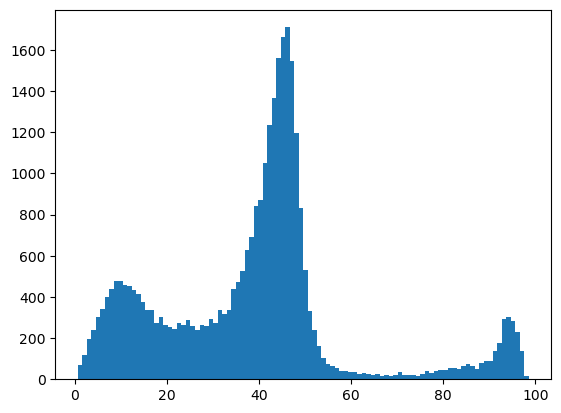

In [7]:
plt.hist(data["means"][data["confidence"] < 40], bins=100)

In [8]:
import sklearn.decomposition as decomposition
PCA_reducer = decomposition.PCA(n_components=3)
reducer_embedding = PCA_reducer.fit_transform(data["latent_space"])

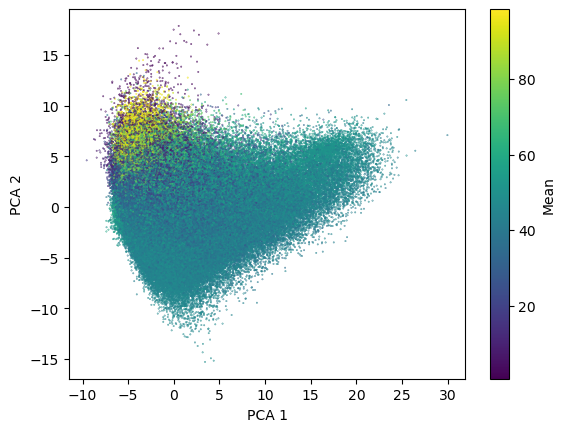

In [109]:
plt.scatter(reducer_embedding[:, 0], reducer_embedding[:, 1], c=data["means"], s=0.1, cmap="viridis")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Mean")

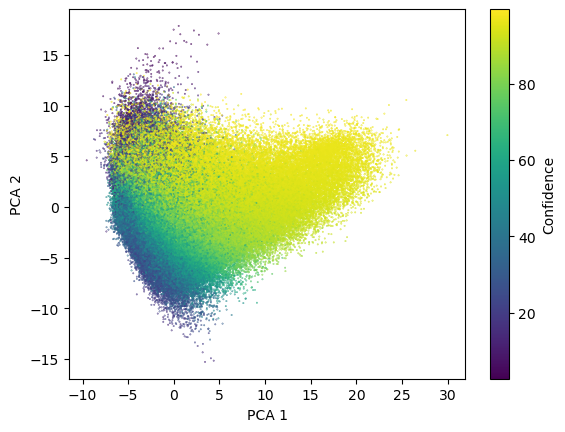

In [108]:
plt.scatter(reducer_embedding[:, 0], reducer_embedding[:, 1], c=data["confidence"], s=0.1, cmap="viridis")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Confidence")

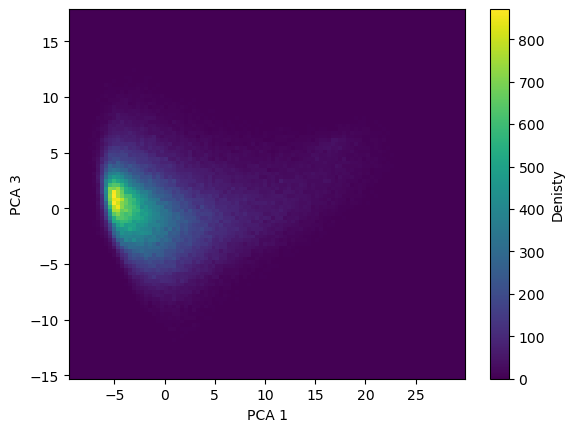

In [83]:
plt.hist2d(reducer_embedding[:, 0], reducer_embedding[:, 1],cmap="viridis", bins=100)
plt.xlabel("PCA 1")
plt.ylabel("PCA 3")
plt.colorbar(label="Denisty")

In [25]:
all_images = img_utils.MRCdataset(mrc_files)
all_images.build_index_map()

Initalizing indexing...


100%|██████████| 1555/1555 [07:15<00:00,  3.57it/s]


In [224]:
idx1 = reducer_embedding[:, 1] < 1
idx2 = reducer_embedding[:, 0] < 10
idx = idx1 & idx2
#idx = reducer_embedding[:, 1] < -10
idx_ = np.where(idx)[0]
print(len(idx_)/len(idx))

0.6135484868794143


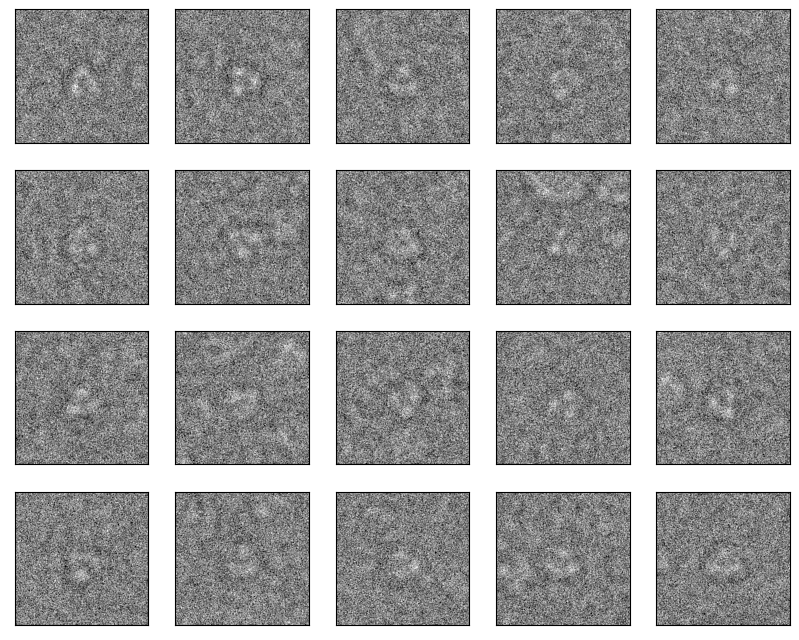

In [225]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(all_images.get_image(int(idx_[i])), vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])
#plt.savefig("images__pca_2>-10.pdf", dpi=500)

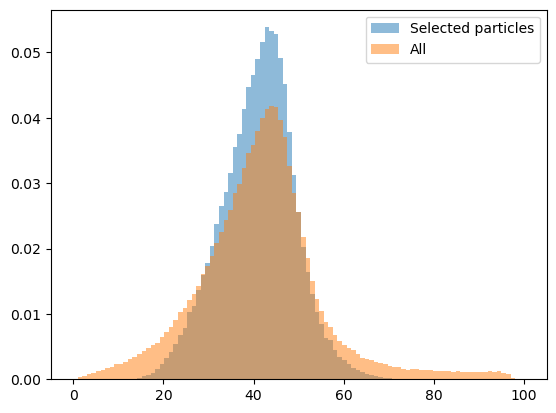

In [232]:
_ = plt.hist(data["means"][idx], bins=np.linspace(0, 100, 100), alpha=0.5, label="Selected particles", density=True)
_ = plt.hist(data["means"], bins=np.linspace(0, 100, 100), alpha=0.5, label="All", density=True)
plt.legend()
plt.savefig("histogram_posterior_mean.pdf", dpi=500)
#plt.vlines(50, 0, 1000, color="red", linewidth=1, linestyle="--")

In [208]:
pca_1 = torch.stack(all_images.get_image(list(idx_)), dim=0)

In [209]:
samples_posterior = est_utils.sample_posterior(
        estimator,
        transform(pca_1.cuda()),
        num_samples=10000,
        batch_size=1000,
        device="cuda",
    )

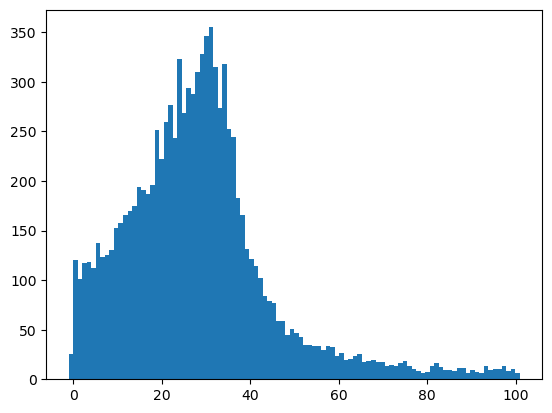

In [210]:
_ = plt.hist(samples_posterior[:, 4], bins=100)

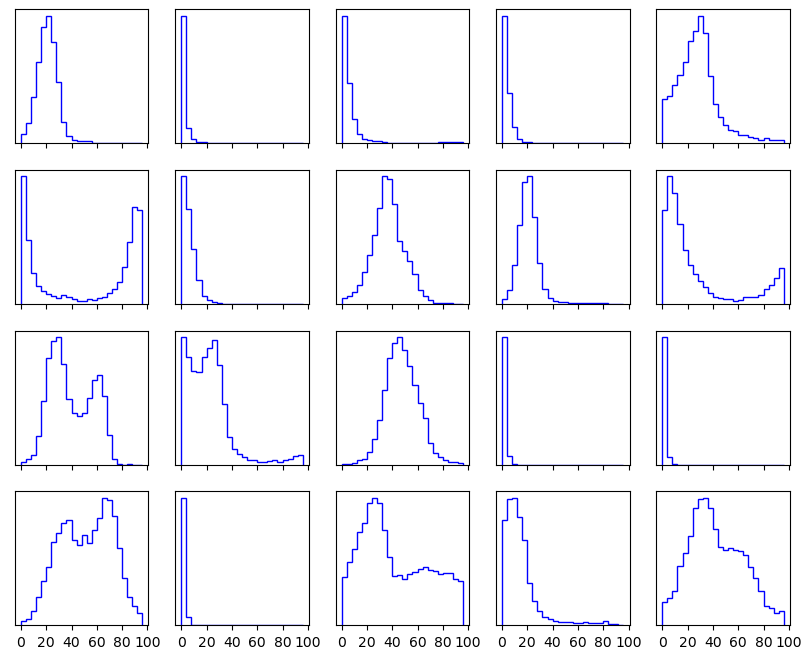

In [211]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for i, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(
        samples_posterior[:, i].flatten().numpy(),
        bins=np.arange(0, 100, 4),
        histtype="step",
        color="blue",
    )
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 101, 20))
plt.savefig("histogram_posteriors_missspecified_ones.pdf", dpi=500)

In [ ]:
idx =[i for i in np.load("cluster_3_indices.npy")[0]]

In [ ]:
mrc_files = img_utils.MRCdataset(mrc_files)

In [ ]:
mrc_files.build_index_map()

In [ ]:
test_images = mrc_files.get_image(idx[:1000])

In [ ]:
plt.imshow(test_images[50])